# Strain mapping of experimental Si/SiGe stacks using correlation approach

These notebooks measure the strain fields of a experimental 4D-STEM dataset which consists of alternating $Si / Si_{0.82}Ge_{0.18}$ multilayer stacks, on a $Si$ substrate, using correlation based approach in py4DSTEM library. The average thickness of the sample is approx. 110 nm as measured form the pure $Si$ region. This tutorial uses the downsampled version of this dataset.

[Downsampled Si/SiGe multilayer experimental dataset](https://drive.google.com/file/d/1fXNYSGpe6w6E9RBA-Ai_owZwoj3w8PNC/view?usp=sharing) (1.2 GB)

[Downsampled vacuum probe](https://drive.google.com/file/d/141Tv0YF7c5a-MCrh3CkY_w4FgWtBih80/view?usp=sharing)

[Estimated Vegard's law strain from EELS composition](https://drive.google.com/file/d/1klkecq8IuEOYB-bXchO7RqOcgCl4bmDJ/view?usp=sharing)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Stephanie Ribet (sribet@lbl.gov)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Experimental data was collected by Steve Zeltmann (steven.zeltmann@berkeley.edu)

Updated 7/17/2023

In [1]:
# Imports
import py4DSTEM
import numpy as np
print('py4DSTEM version: {}'.format(py4DSTEM.__version__))

py4DSTEM version: 0.14.2


# Load data

In [3]:
# Set filepaths

dirpath = '/Users/Ben/work/data/py4dstem_sampledata/Si_SiGe/'
filepath_data = dirpath + 'downsample_Si_SiGe_exp.h5'
filepath_probe = dirpath + 'downsample_Si_SiGe_probe.h5'
filepath_partial_analysis = dirpath + 'downsample_Si_SiGe_analysis_'
filepath_compare = dirpath + 'Si_SiGe_EELS_strain.mat'

In [4]:
# Load data

dataset = py4DSTEM.read(filepath_data, data_id='datacube_0')
dataset_probe = py4DSTEM.read(filepath_probe, data_id='datacube_0')

# check data shape
print(dataset.data.shape)
print(dataset_probe.data.shape)

(50, 200, 128, 128)
(1, 1, 128, 128)


# Examine the data 

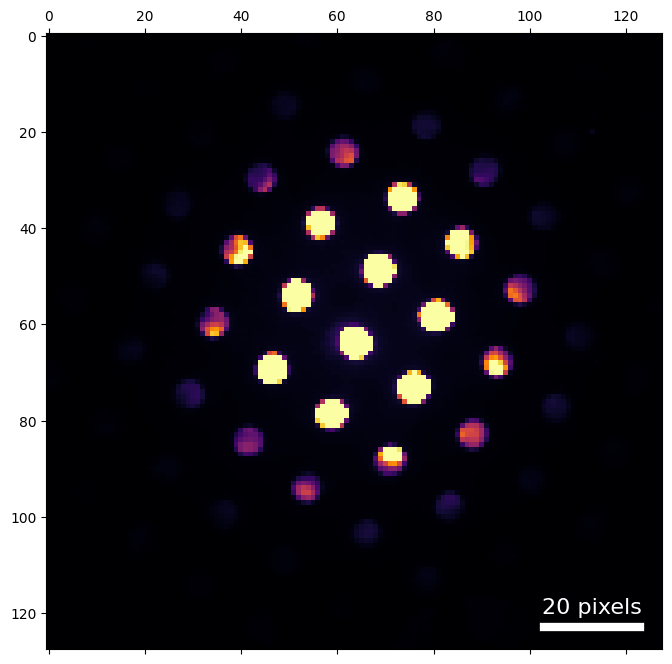

In [5]:
# Mean diffraction pattern of the dataset

# compute
dp_mean = dataset.get_dp_mean()

# show
py4DSTEM.show(
    dp_mean,
    cmap='inferno'
)

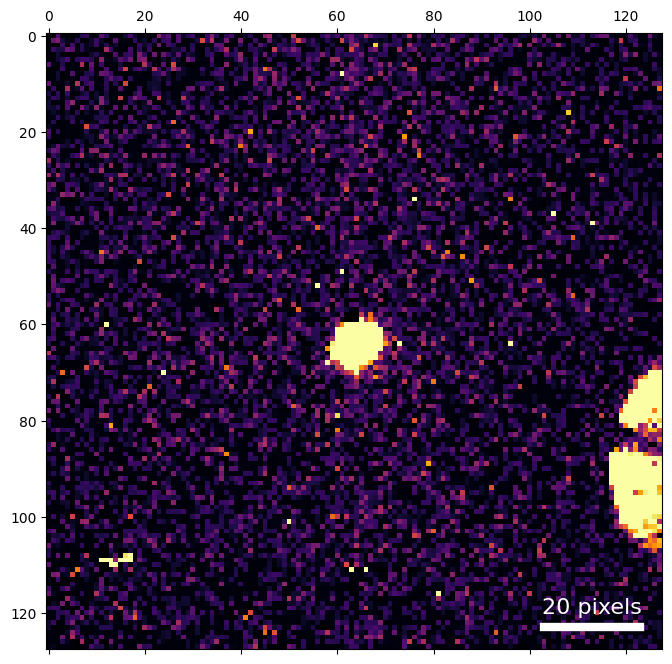

In [6]:
# Mean diffraction pattern of the probe

# compute
probe_dp_mean = dataset_probe.get_dp_mean()

# show
py4DSTEM.show(
    probe_dp_mean,
    cmap = 'inferno',
)

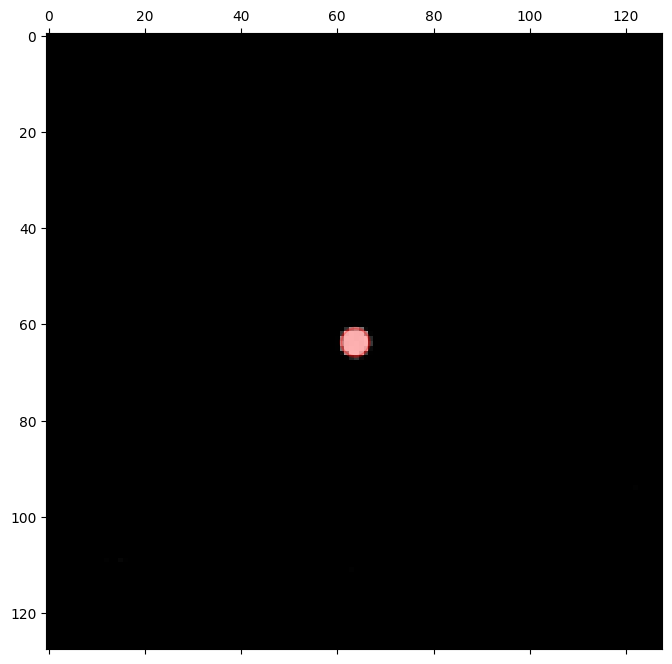

In [7]:
# Estimate the radius of the BF disk, and the center coordinates

probe_semiangle, probe_qx0, probe_qy0 = dataset_probe.get_probe_size(plot = True)

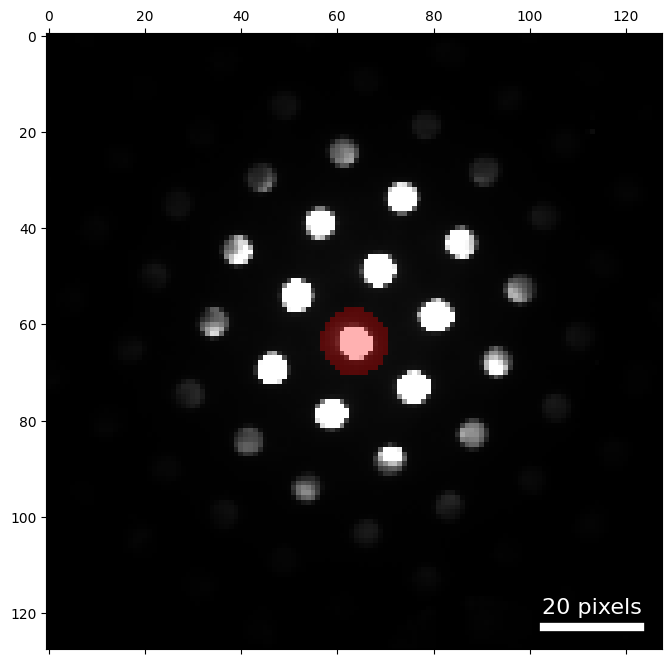

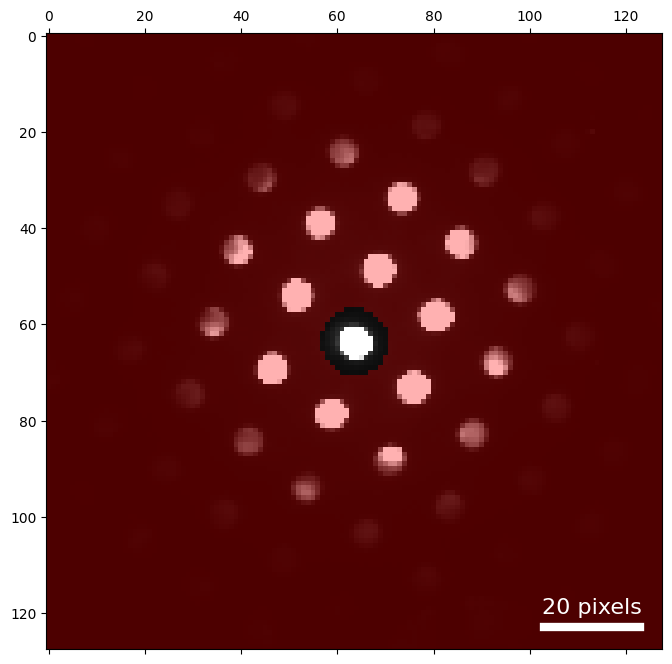

In [8]:
# Virtual imaging - position the detectors

# We'll generate a bright-field (BF) and an annular dark-field (ADF) virtual image


# set the detector geometries
expand_BF = 4.0
center = (probe_qx0, probe_qy0)
radius = probe_semiangle + expand_BF       # BF
radii = (probe_semiangle + expand_BF, 1e3) # ADF - everything outside the BF disk

# display the detector positions
dataset.position_detector(
    mode = 'circle',
    geometry = (center,radius),
)
dataset.position_detector(
    mode = 'annulus',
    geometry = (center,radii),
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21383.29it/s]


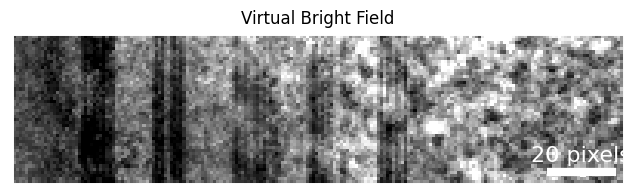

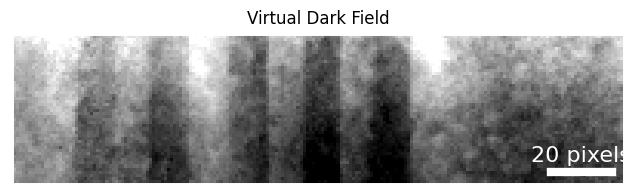

In [9]:
# Virtual imaging - compute the images


# compute
im_bf = dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field',
)

im_adf = dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii),
    name = 'dark_field',
)

# show
py4DSTEM.show(
    im_bf,
    figsize=(16,2),
    bordercolor = 'w',
    cmap='gray',
    title='Virtual Bright Field',
)
py4DSTEM.show(
    im_adf,
    figsize=(16,2),
    bordercolor = 'w',
    cmap = 'gray',
    title='Virtual Dark Field',
)

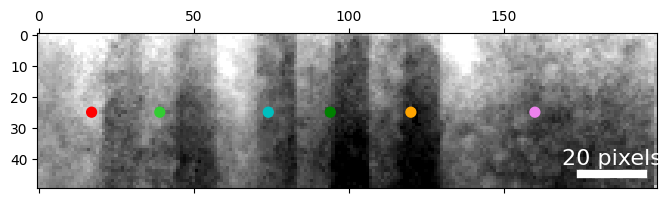

In [10]:
# Choose some diffraction patterns to use for hyperparameter tuning

rxs = 25, 25, 25, 25, 25, 25
rys = 17, 39, 74, 94, 120, 160
colors=['r','limegreen','c','g','orange', 'violet']

py4DSTEM.visualize.show_points(
    im_adf,
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# Construct probe template

In [11]:
probe = dataset_probe.get_vacuum_probe()

0it [00:00, ?it/s]


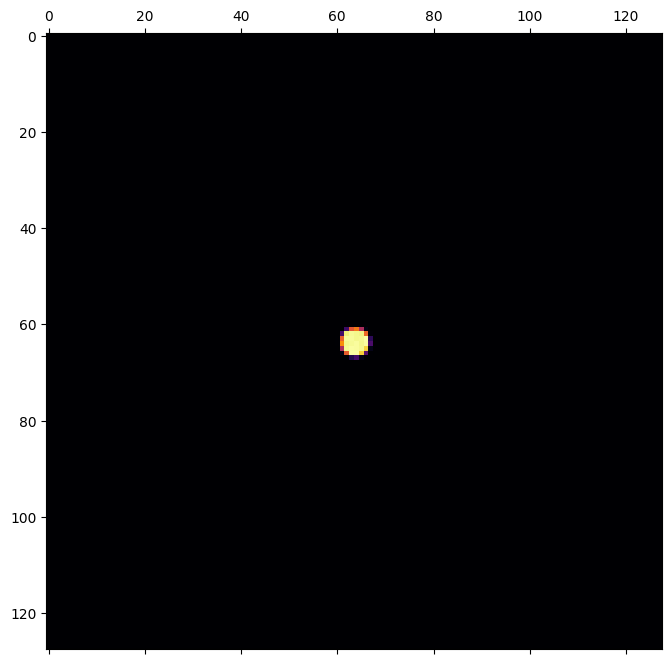

In [12]:
py4DSTEM.show(
    probe.probe,
    cmap='inferno',
    intensity_range = 'ordered', 
    vmin = 0, 
    vmax = 1
)

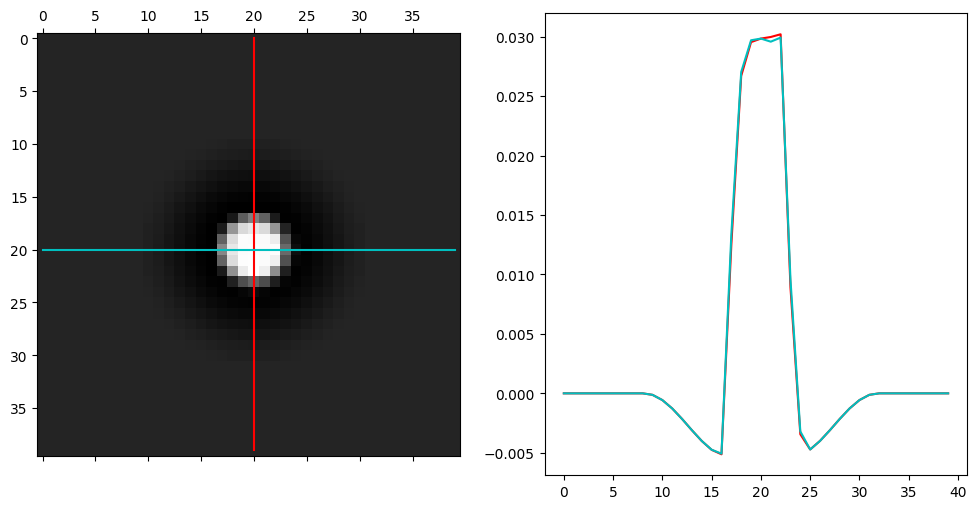

In [13]:
probe_kernel = probe.get_kernel(
    mode = 'sigmoid',
    radii = (probe_semiangle * 1.0, probe_semiangle * 4.0)
)

py4DSTEM.visualize.show_kernel(
    probe_kernel,
    R = 20,
    L = 20,
    W = 1
)

# Find Bragg Peaks

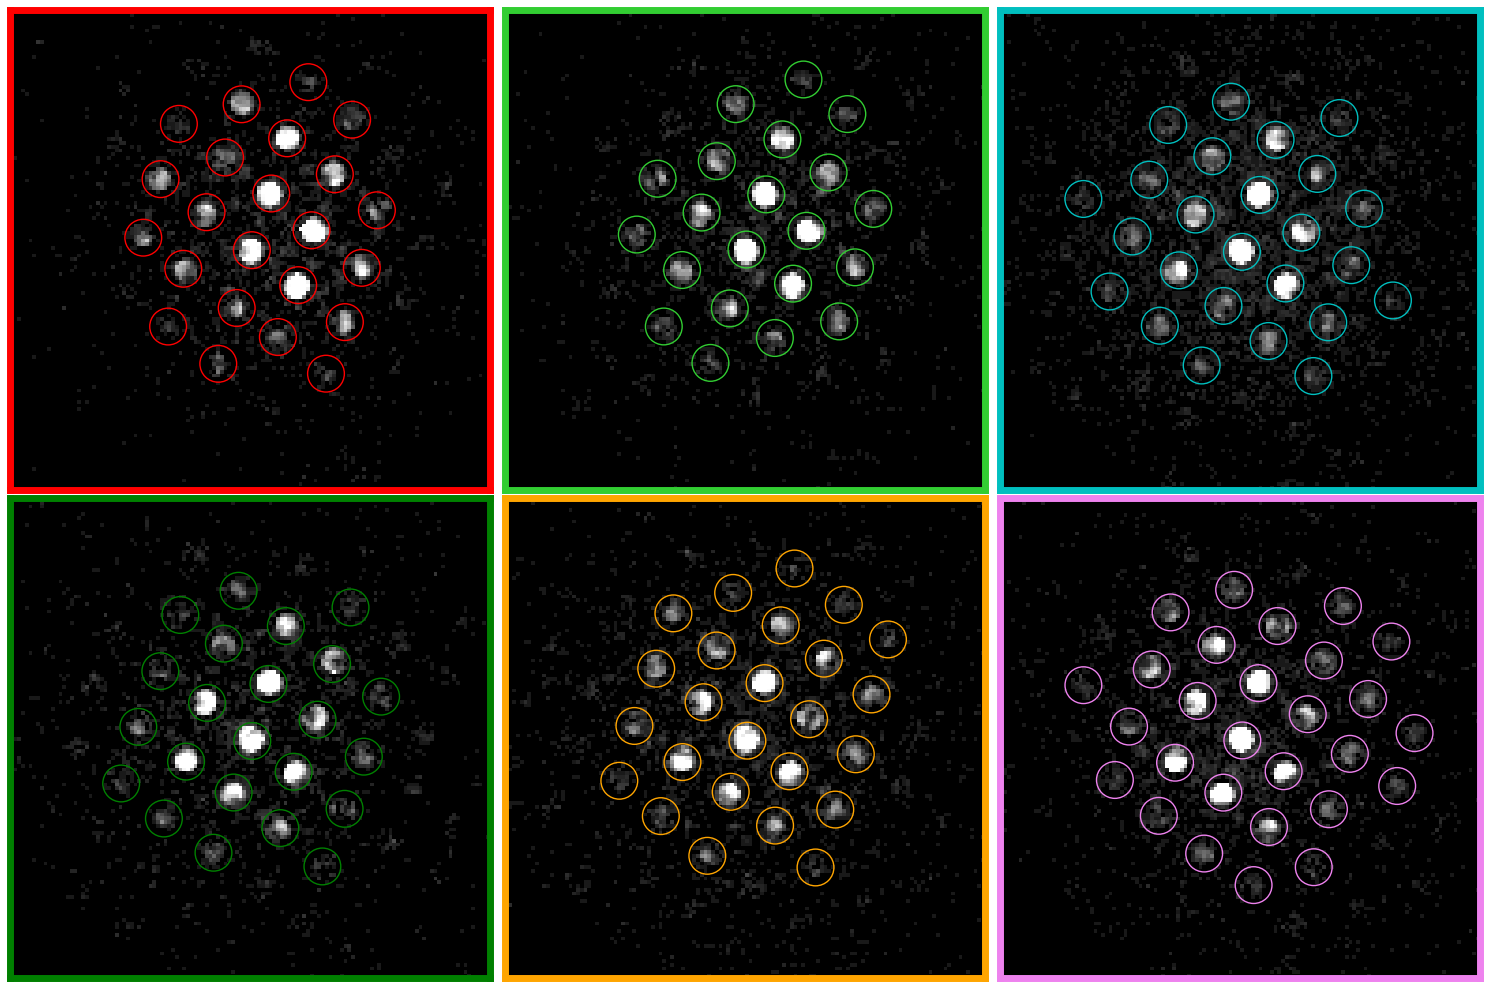

In [14]:
# Test disk detection parameters on a few probe positions
# Visualize the selected diffraction patterns and their located disk positions


# disk detection parameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 16,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 1,
    'minPeakSpacing': 8,
    'subpixel': 'poly',
    # 'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=0,
    vmax=100,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [15]:
# Find Bragg peaks in all probe positions.
# Note that "poly" subpixel fitting can be used to keep this tutoral fast, but "multicorr"
# is more accurate. For high precision strain mapping, subpixel="multicorr" is recommended!

braggpeaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.0k/10.0k [00:22<00:00, 439DP/s]


In [16]:
# # Optionally, you may want to save the peak data at this point

# # set a filepath
filepath_braggdisks_raw = filepath_partial_analysis + 'braggdisks_raw.h5'
# save
py4DSTEM.save(
    filepath_braggdisks_raw,
    braggpeaks,
    mode='o',      # overwrite mode
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4718.86it/s]


In [17]:
# if you do, you can later return to this point in the notebook and load thusly

# set the filepath
filepath_braggdisks_raw = filepath_partial_analysis + 'braggdisks_raw.h5'
# inspect the file contents
py4DSTEM.print_h5_tree(filepath_braggdisks_raw)
# read the bragg vectors
braggpeaks = py4DSTEM.read(
    filepath_braggdisks_raw, 
    root = 'datacube_0_root/braggvectors'
)
braggpeaks

/
|---datacube_0_root
    |---braggvectors
        |---_v_uncal




Reading PointListArray: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4150.24PointList/s]


BraggVectors( A (50, 200)-shaped array of lists of bragg vectors )

# Center coordinate system

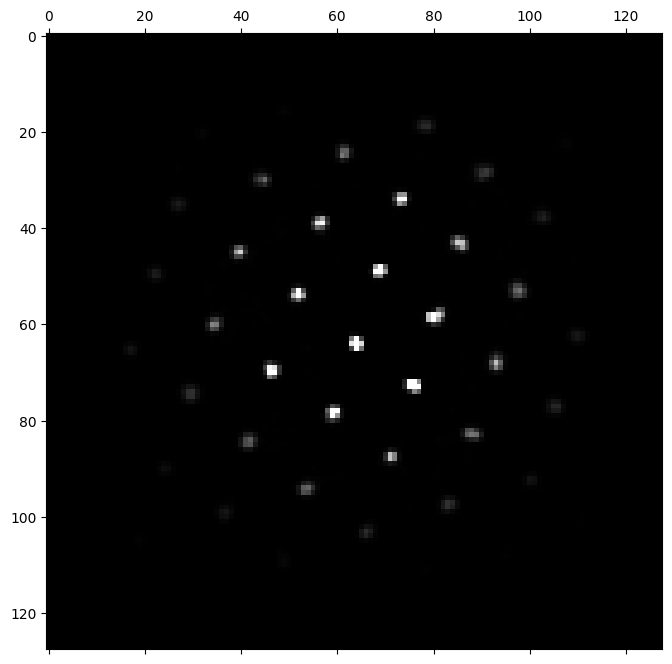

In [18]:
# Compute a Bragg vector map,
# i.e. a 2D histogram of the Bragg peak positions,
# weighted by their correlation intensities

bvm_raw = braggpeaks.histogram(mode = 'raw')

# Plot the BVM
bvm_vis_params = {
    'scaling':'power',
    'power':0.5,
    'intensity_range':'absolute',
    'vmin':0,
    'vmax':1e5
}
py4DSTEM.show(
    bvm_raw,
    **bvm_vis_params
)

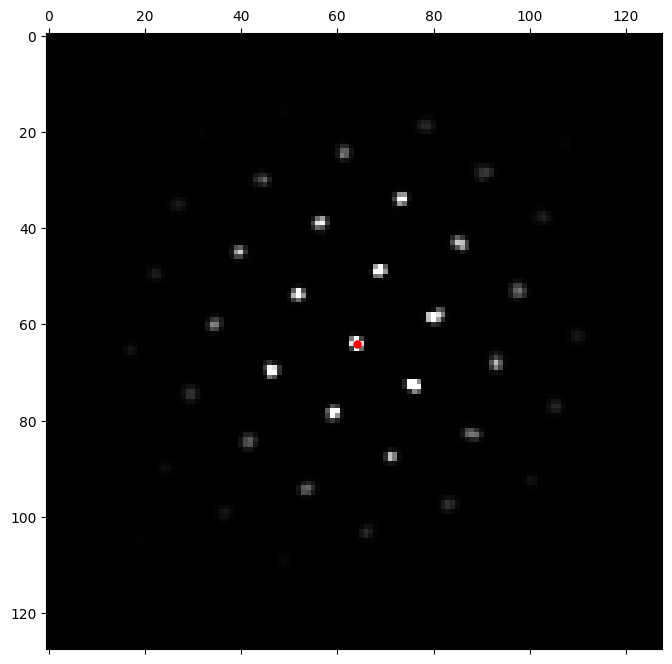

In [19]:
# Initial guess for the center position

center_guess = 64, 64

py4DSTEM.show(
    bvm_raw,
    points = {'x':center_guess[0],'y':center_guess[1]},
    **bvm_vis_params,
)

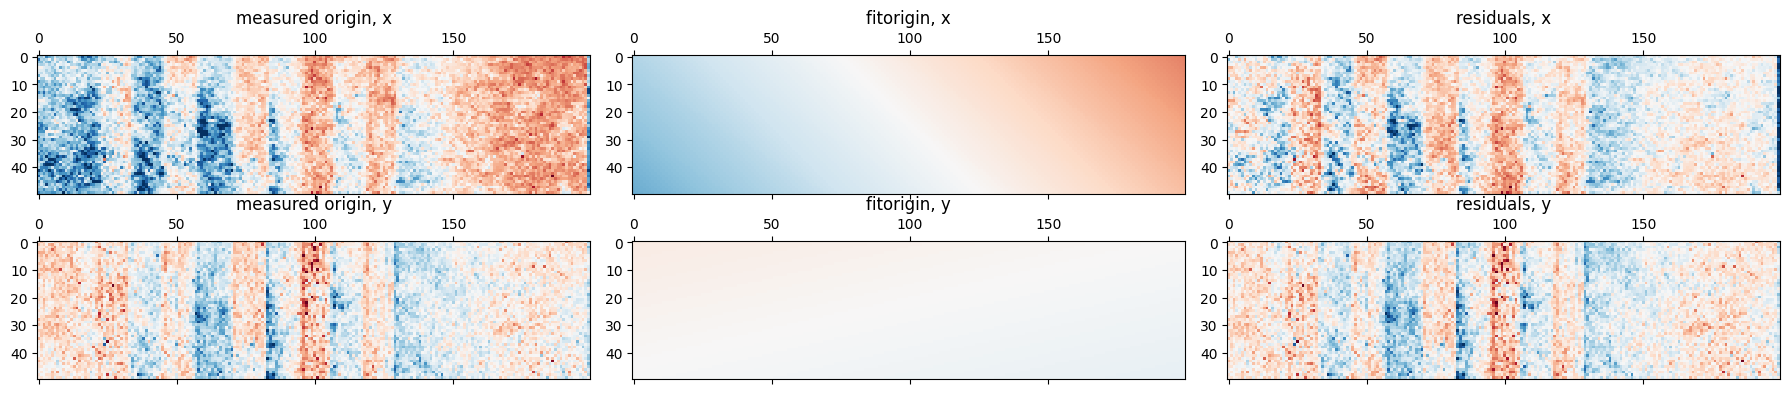

In [20]:
# Find the origin at each beam position

# measure the origin
origin_meas = braggpeaks.measure_origin( center_guess=center_guess )
# fit a 2D plane
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = braggpeaks.fit_origin()


# Note that the residuals of our fit are large - this is expected.  The first line of
# code above measures the center the central disk, which is a good approximation of the
# origin of diffraction space but is quite distinct from it. Physically the shift of the
# center of mass (not exactly what we measured, but close) scales with the derivative of
# the sample potential (the eponymous DPC signal), so as long as this is nonzero we had
# better have residuals to this fit!

# In fitting a plane or parabolic surface to the measured shifts of the approximate
# origin, we aim to capture the systematic shift of the beam due to the changing scan
# coils, while removing as little physically meaningful signal we can.

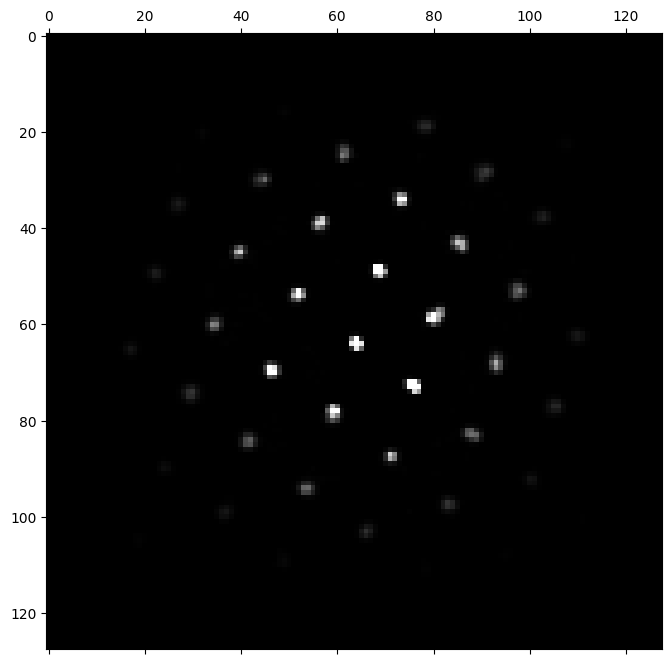

In [21]:
# Get the Bragg vector map after after centering using our new origin measurements

# compute
bvm_centered = braggpeaks.histogram()

# show
py4DSTEM.show(
    bvm_centered,
    **bvm_vis_params,
)

In [22]:
# # save

# filepath_braggdisks_raw = filepath_partial_analysis + 'braggdisks_cal.h5'
# py4DSTEM.save(
#     filepath_braggdisks_raw,
#     braggpeaks,
#     mode='o',      # overwrite mode
# )

In [23]:

# filepath_partial_analysis = dirpath + 'downsample_Si_SiGe_analysis_'
# filepath_braggdisks_raw = filepath_partial_analysis + 'braggdisks_cal.h5'

# # variables
# bvm_vis_params = {
#     'scaling':'power',
#     'power':0.5,
#     'intensity_range':'absolute',
#     'vmin':0,
#     'vmax':1e5
# }

# #py4DSTEM.print_h5_tree(filepath_braggdisks_raw)
# braggpeaks = py4DSTEM.read(
#     filepath_braggdisks_raw, 
#     root = 'datacube_0_root/braggvectors'
# )
# braggpeaks

# Strain

In [24]:
strainmap = py4DSTEM.StrainMap( braggvectors=braggpeaks )

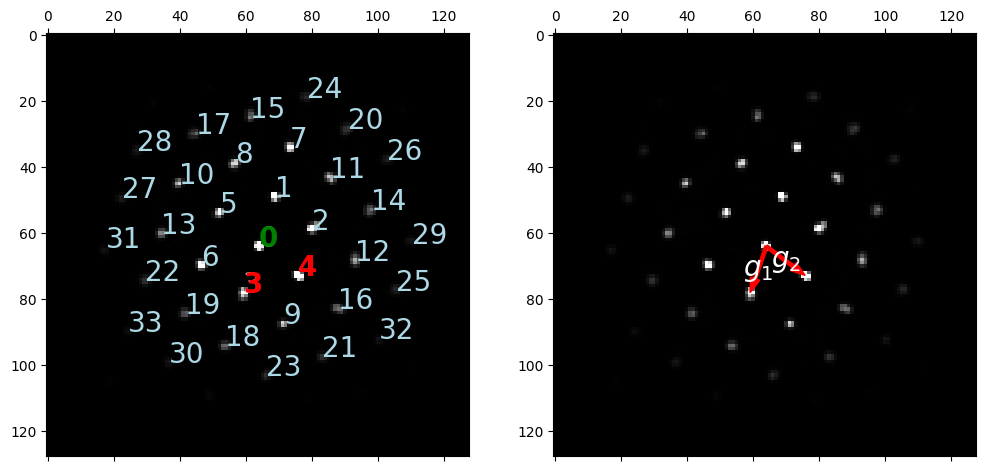

In [25]:
strainmap.choose_lattice_vectors(
    index_g0=0,
    index_g1=3,
    index_g2=4,
    minSpacing=13,
    minAbsoluteIntensity=1e2,
    maxNumPeaks=100,
    vis_params = bvm_vis_params,
)

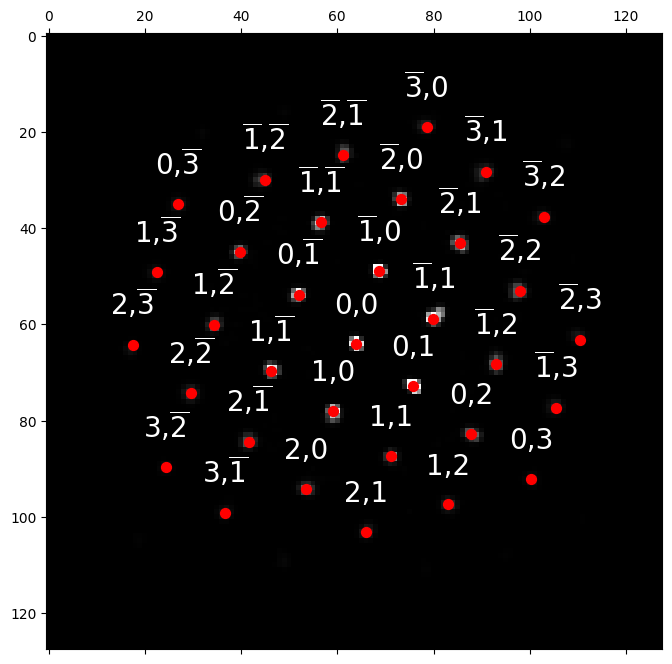

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2106.80it/s]


In [26]:
strainmap.fit_lattice_vectors(
    max_peak_spacing = 2,
    vis_params = bvm_vis_params,
    returncalc=True
)

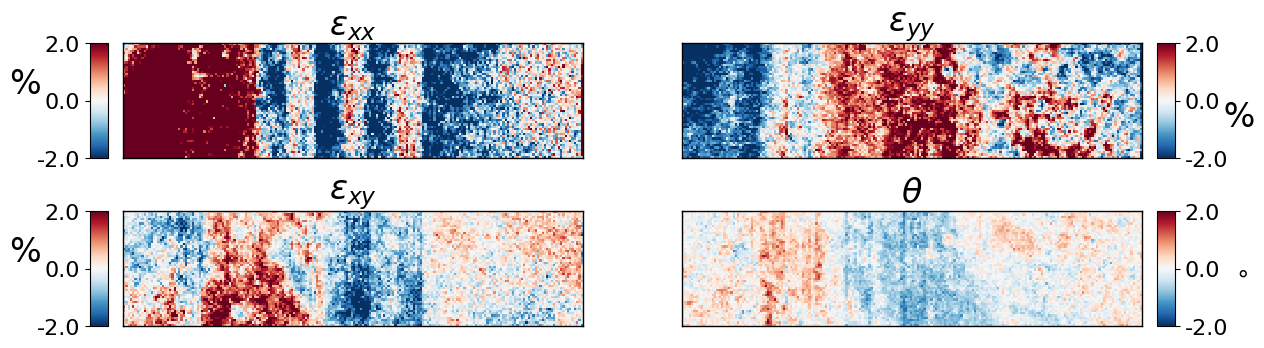

In [27]:
#median strain map
strainmap.get_strain(
    mask = None,
    # vrange_exx = [-4.0, 4.0],
    # vrange_theta = [-3.0, 3.0],
)

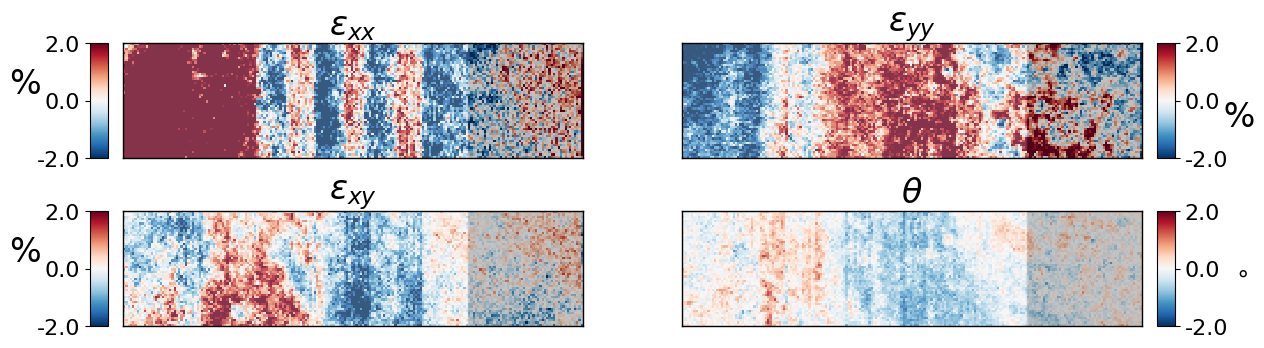

In [28]:
#strain from a region

mask = np.ones(braggpeaks.Rshape)
x0,xf = 0,50
y0,yf = 150, 200
mask[:] = False
mask[x0:xf,y0:yf] = True
mask = np.array(mask, dtype = "bool")

strainmap_region = strainmap.copy()
strainmap_region.get_strain(
    mask = mask,
    # vrange_exx = [-4.0, 4.0],
    # vrange_theta = [-3.0, 3.0],
)

# Plot line traces for the mean strain values

In [29]:
import h5py
# Now load the experimental strain profile measured from the EELS composition map

eels_data = h5py.File(filepath_compare,'r') 
imGe = np.asarray(eels_data['imGe'])
imSi = np.asarray(eels_data['imSi'])
strain_exp = 1.275*np.asarray(eels_data['strain'])
wGe = np.asarray(eels_data['wGe'])
wSi = np.asarray(eels_data['wSi'])

In [30]:
# Estimated strain profile from STEM-EELS
probe_step_x_ = np.arange(0,strainmap_region.shape[1])
strain_ideal_e_xx = np.mean(strain_exp, axis=0)
strain_ideal_e_yy = np.zeros_like(probe_step_x_)

In [31]:
import matplotlib.pyplot as plt

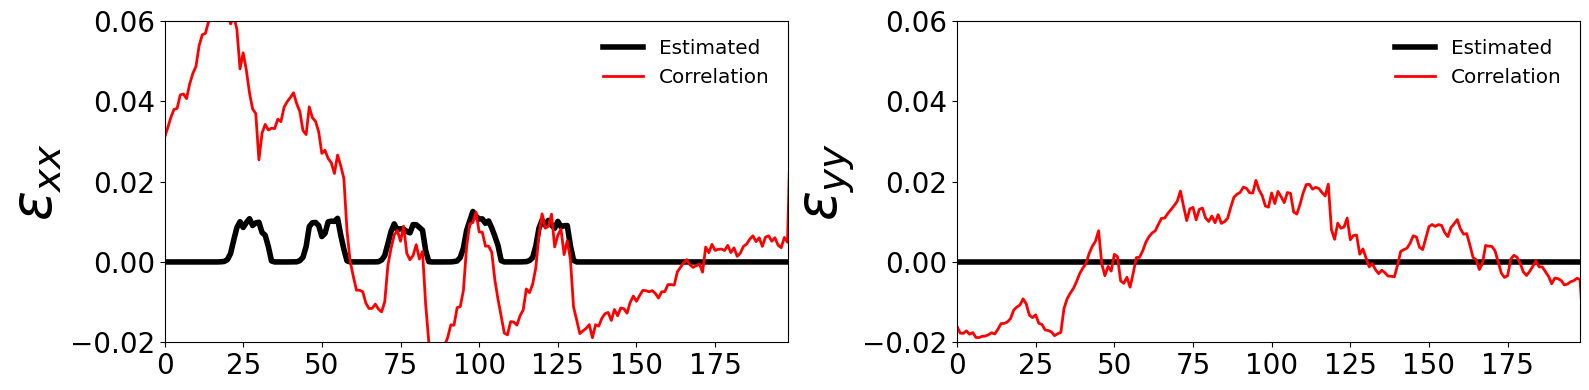

In [32]:
# Get mean E_xx and E_yy strain maps along the perpendicular to growth direction
strain_mean_e_xx_corr = np.mean(strainmap_region.strainmap_rotated.get_slice('e_xx').data,axis=0)
strain_mean_e_yy_corr = np.mean(strainmap_region.strainmap_rotated.get_slice('e_yy').data,axis=0)

# Plotting
fig, axs = plt.subplots(1,2,figsize=(16,4))

# strain along x direction
axs[0].plot(
    probe_step_x_, 
    np.roll(strain_ideal_e_xx, -3),
    color = 'k',
    linestyle = '-', linewidth = 4, label = 'Estimated');
axs[0].plot(
    probe_step_x_, 
    strain_mean_e_xx_corr,
    color = 'r', linewidth = 2, label = 'Correlation')
axs[0].set_xlim(0,198)
axs[0].set_ylim(-0.02,0.06)

# strain along y direction
axs[1].plot(
    probe_step_x_, 
    np.roll(strain_ideal_e_yy,-10),
    color = 'k',
    linestyle = '-', linewidth = 4, label = 'Estimated');
axs[1].plot(
    probe_step_x_, 
    strain_mean_e_yy_corr,
    color = 'r', linewidth = 2, label = 'Correlation')
axs[1].set_xlim(0,198)
axs[1].set_ylim(-0.02,0.06)

axs[0].legend(frameon = False, fontsize = 'x-large')
axs[1].legend(frameon = False, fontsize = 'x-large')
axs[0].locator_params(axis = "y", nbins = 4)
axs[1].locator_params(axis = "y", nbins = 4)
axs[0].locator_params(axis = "x", nbins = 8)
axs[1].locator_params(axis = "x", nbins = 8)
axs[0].tick_params(axis = 'both', which = 'major', labelsize = 20)
axs[1].tick_params(axis = 'both', which = 'major', labelsize = 20)
#ax.set_yticklabels(xlabels, fontsize= )
axs[0].set_ylabel(r'$\epsilon_{xx}$', fontsize = 40)
axs[1].set_ylabel(r'$\epsilon_{yy}$', fontsize = 40)
plt.tight_layout()
#fig.savefig('./paper_figs/strain_profile_exp_thin.pdf', dpi=600)
plt.show()

Note that this strain map looks pretty bad, due to the thickness of the sample and the large binning factor we used here.  The original resolution data produces much better strain maps.